# Zillow Estimate Project

Zillow is an online real estate database with data on homes across the United States. One of Zillow’s most popular features is a proprietary property value prediction algorithm: the Zestimate.  As one might imagine, Zillow is constantly trying to improve its Zestimate. In this notebook we will improve our original estimate of the log error by using clustering methodologies.

#### Items that should hopefull change the result:

- make sure we cluster the right feature/features
- total up the private areas rooms
- focus on binning the right features with the right abount of bins; only way to see what that number is will be to test, test, test
- use multiple methods to determine the best method to use

In [273]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import important files from local file
import acquire_zillow
import prepare_zillow

# brining in the basics
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# the following will be used to model and test our data 
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from scipy.stats import pearsonr
from scipy.stats import iqr

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from sklearn.ensemble import GradientBoostingClassifier

In [127]:
df = acquire_zillow.read_zillow_csv()

In [128]:
prepare_zillow.prep_zillow(df)

In [129]:
df = df[df.propertylandusedesc != 'Duplex (2 Units, Any Combination)']
df = df[df.propertylandusedesc != 'Quadruplex (4 Units, Any Combination)']
df = df[df.propertylandusedesc != 'Triplex (3 Units, Any Combination)']
df = df[df.propertylandusedesc != 'Condominium']

In [130]:
unit_one = df[(df['unitcnt'] >= 2) & (df['bedroomcnt'] >= 2) & (df['calculatedfinishedsquarefeet'] >= 500)].index    
df.drop(unit_one, inplace=True)

In [131]:
columns_to_remove = ['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'heatingorsystemdesc',
                     'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'finishedfloor1squarefeet', 
                     'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'propertylandusedesc',
                     'finishedsquarefeet6', 'fireplacecnt', 'hashottuborspa',  'propertyzoningdesc', 'rawcensustractandblock', 
                     'heatingorsystemtypeid', 'poolsizesum', 'propertycountylandusecode', 'propertylandusetypeid', 
                     'pooltypeid10', 'pooltypeid2', 'pooltypeid7','regionidcounty', 'regionidneighborhood', 
                     'roomcnt', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'regionidcity',
                     'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag',
                     'taxdelinquencyflag', 'taxdelinquencyyear', 'transactiondate', 'finishedsquarefeet12',
                     'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']
df = df.drop(columns_to_remove, axis=1)

Here we want to give a small insight into the logerror; and to be sure that the logerror is normally distributed. This is an important step for maintaining the consistent distribution and performance throughout the notebook.

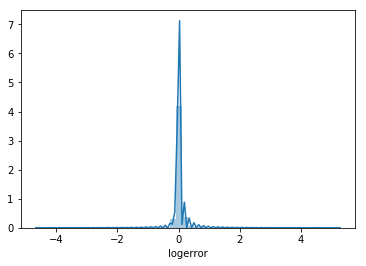

In [132]:
sns.distplot(df.logerror)
fig.suptitle('Distrobution of Log Error')

4. Impute the values in land square feet.

For land square feet, the goal is to impute the missing values by creating a linear model where landtaxvaluedollarcnt is the x variable and the output/y-variable is the estimated land square feet. We'll then use this model to make predictions and fill in the missing values.

Write a function that accepts the zillow data frame and returns the data frame with the missing values filled in.

In [133]:
def replace_null_data(df, column_name, numerical = True):
    if numerical == True:
        df[column_name] = df[column_name].fillna(df[column_name].mean())
    else:
        df[column_name] = df[column_name].fillna(df[column_name].mode()[0])
    
    return df

df = replace_null_data(df,'landtaxvaluedollarcnt')
df = replace_null_data(df,'yearbuilt')
df = replace_null_data(df,'unitcnt')
df = replace_null_data(df, 'calculatedfinishedsquarefeet')
df = replace_null_data(df, 'lotsizesquarefeet')

5. Create a function that fills missing values with 0s. Explore the data and decide which columns it makes sense to apply this transformation to.

In [134]:
def replace_with_zero(df, column_name):
    df[column_name] = df[column_name].fillna(0)
    return df

df = replace_with_zero(df, 'taxvaluedollarcnt')
df = replace_with_zero(df, 'regionidzip')
df = replace_with_zero(df, 'garagecarcnt')
df = replace_with_zero(df, 'garagetotalsqft')
df = replace_with_zero(df, 'poolcnt')

6. Run the first function that returns missing value totals by column: Does the attribute have enough information (i.e. enough non-null values) to be useful? Choose your cutoff and remove columns where there is not enough information available. Document your cutoff and your reasoning.

**Documentation of missing values by column:**

Each attribute in the Zillow data could be useful; I chose to look at all the numerical types and fill columns with the NaN value with the mean, and the non-numerical columns with the mode. I am hoping to look at the NaN information in a generalized form; i.e. in a way that it would create a bias in each column towards the mean of that column.

There are columns that will not have a place during and after the train test split and we will look at those further in detail. Currently there are around 100k rows to look at which is plenty of rows to see how each column effects logerror.

7. Run the function that returns missing values by row: Does the observation have enough information to use in our sample? Choose your cutoff and remove rows where there is not enough information available. Document your cutoff and your reasoning.

**Documentation of missing values by row:**

Taking a look at each row comes into play when we want to eliminate certain descriptions of propertylandusedesc from our prepared data. Part of the reasoning of just looking at single unit listings is to focus on the majority. There are around 100k single unit properties while there are only half that of the multi unit properites.

I chose to eliminate Duplex's, Triplex, Quadruplex, and Condominium since these are known to have multi units within each building. The rest of the descriptions could go either way so I created a different function that would eliminate through a different column: 'unitcnt'

8. Of the remaining missing values, can they be imputed or otherwise estimated?

    - Impute those that can be imputed with the method you feel best fits the attribute.
    - Decide whether to remove the rows or columns of any that cannot be reasonably imputed.
    - Document your reasons for the decisions on how to handle each of those.


#### Handle Outliers

In [135]:
keys = ['bathroomcnt','bedroomcnt','calculatedfinishedsquarefeet',
                      'structuretaxvaluedollarcnt','landtaxvaluedollarcnt']
values = [(1,7), (1,7), (500,8000), (25000,2000000), (10000,2500000)]

dictionary = dict(zip(keys, values))

for key, value in dictionary.items():
    df = df[df[key] >= value[0]]
    df = df[df[key] <= value[1]]

In [136]:
def summarize_df(df):
    print("\nRows & Columns:\n")
    print(df.shape)
    print("\nColumn Info:\n")
    print(df.info())
    print("\nFirst 5 rows:\n")
    print(df.head())
    print("\nLast 5 rows:\n")
    print(df.tail())
    print("\nMissing Values:\n")
    missing_vals = df.columns[df.isnull().any()]
    print(df.isnull().sum())
    print("\nSummary Stats:\n")
    print(df.describe())
    print("\nColumn IQR:\n")
    var_names = df.columns.values
    for var in var_names:
        print(var+":")
        print(iqr(df[var],axis=0))

In [137]:
summarize_df(df)


Rows & Columns:

(112776, 24)

Column Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112776 entries, 11016594 to 12826780
Data columns (total 24 columns):
id                              112776 non-null int64
bathroomcnt                     112776 non-null float64
bedroomcnt                      112776 non-null float64
calculatedbathnbr               112751 non-null float64
calculatedfinishedsquarefeet    112776 non-null float64
fips                            112776 non-null float64
fullbathcnt                     112751 non-null float64
garagecarcnt                    112776 non-null float64
garagetotalsqft                 112776 non-null float64
latitude                        112776 non-null float64
longitude                       112776 non-null float64
lotsizesquarefeet               112776 non-null float64
poolcnt                         112776 non-null float64
regionidzip                     112776 non-null float64
unitcnt                         112776 non-null floa

### Explore -- Zillow Data

Write a function that will take, as input, a dataframe and a list containing the column names of all ordered numeric variables. It will output, through subplots, a pairplot, a heatmap, and 1 other type of plot that will loop through and plot each combination of numeric variables (an x and a y, combination order doesn't matter here!).

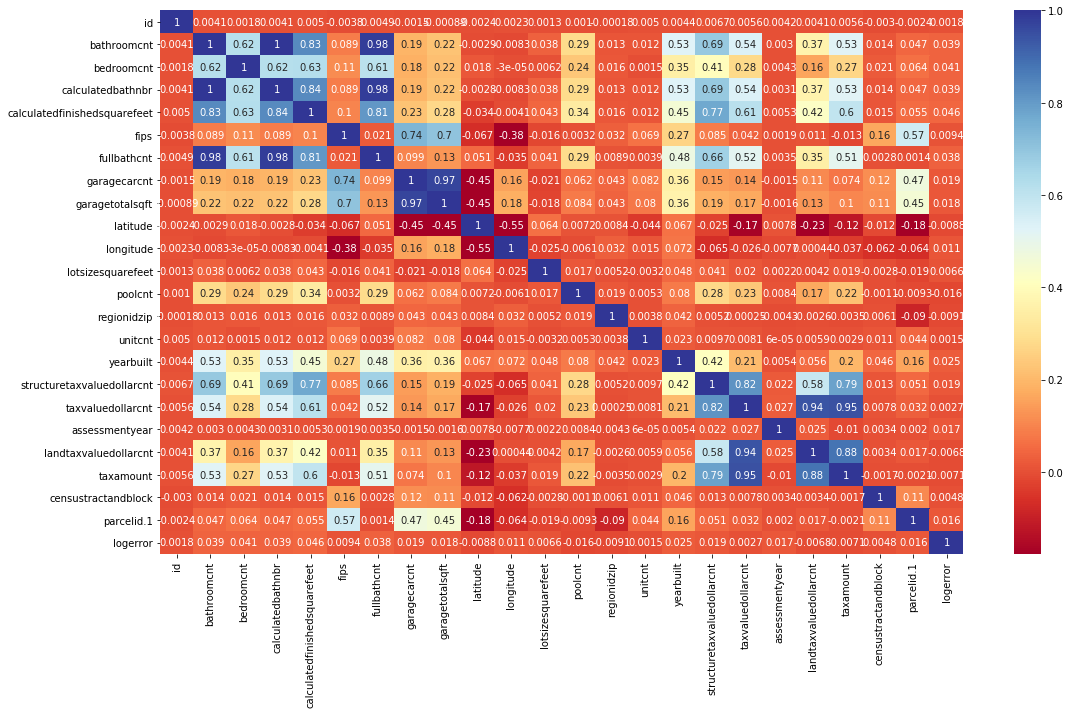

In [138]:
num_cols = df.select_dtypes(exclude=['object'])

plt.figure(figsize=(18,10))
sns.heatmap(num_cols.corr(), annot=True, cmap='RdYlBu', robust=True)

**Correlation Multivariant**

Other than the heatmap there are plenty of differnt comparisons we can look at; the cell below will look at 555 different combinations and their correlations. It will also rank them from worst to greatest

In [277]:
corrs = df.corr().abs().unstack().sort_values(kind="quicksort").reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(20)

,level_0,level_1,0
1036,private_areas_cnt,bedroomcnt,0.894830
1037,bedroomcnt,private_areas_cnt,0.894830
1038,private_areas_cnt,bathroomcnt,0.905053
1039,bathroomcnt,private_areas_cnt,0.905053
1040,private_areas_cnt,calculatedbathnbr,0.905059
1041,calculatedbathnbr,private_areas_cnt,0.905059
1042,cluster_0,cluster,0.914494
1043,cluster,cluster_0,0.914494
1044,landtaxvaluedollarcnt,taxvaluedollarcnt,0.944323
1045,taxvaluedollarcnt,landtaxvaluedollarcnt,0.944323


## Feature Engineering

**New Variable Created:** "absolute_logerror" will return a list of absolute values of the logerror

In [140]:
df['absolute_logerror']= abs(df['logerror'])

Text(0.5, 0.98, 'Distrobution of Absolute Log Error')

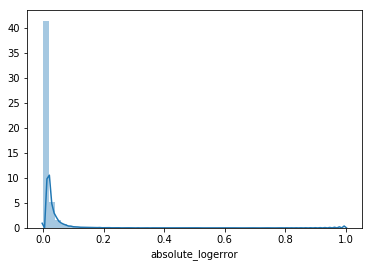

In [264]:
sns.distplot(df.absolute_logerror)
fig.suptitle('Distrobution of Absolute Log Error')

**New Feature Created:** "private_areas_cnt" adds the two features of bathroom count and bedroom count together to form private areas

In [141]:
df['private_areas_cnt'] = df['bedroomcnt'] + df['bathroomcnt']

Text(0.5, 0.98, 'Distrobution of Private Areas')

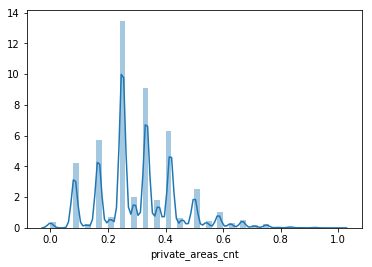

In [267]:
sns.distplot(df.private_areas_cnt, norm_hist=True)
fig.suptitle('Distrobution of Private Areas')

Here we are looking to see if there is a relationship between our new variable and absolute logerror

**Messing with logerror**

We need to figure out what to do with logerror: Chose to take the absolute value of the logerror because I didn't really care/understand weather or not the value was either negative or positive

**New Variable Created:** "logerror_bin" creates 4 different buckets containing equal amounts of zestimates however the each bucked is weighted from a 0 to 3 scale; 3 is the worst zestimate

In [142]:
df['logerror_bin'] = pd.qcut(df.absolute_logerror, 4, labels=["LVL_1(Good)", "LVL_2", "LVL_3", "LVL_4(Bad)"])

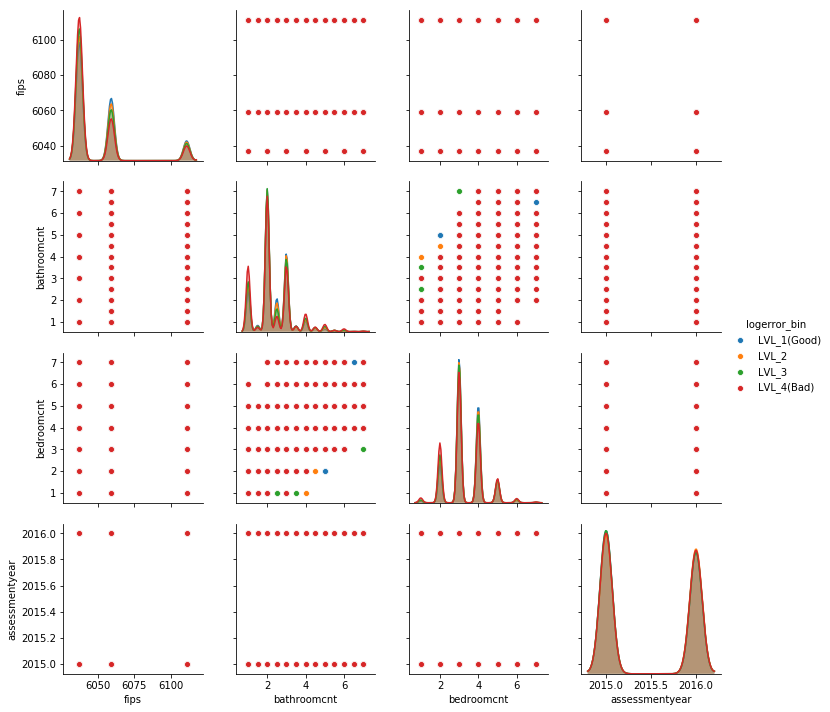

In [143]:
sns.pairplot(df, vars=['fips', 'bathroomcnt', 'bedroomcnt', 'assessmentyear'], hue='logerror_bin')

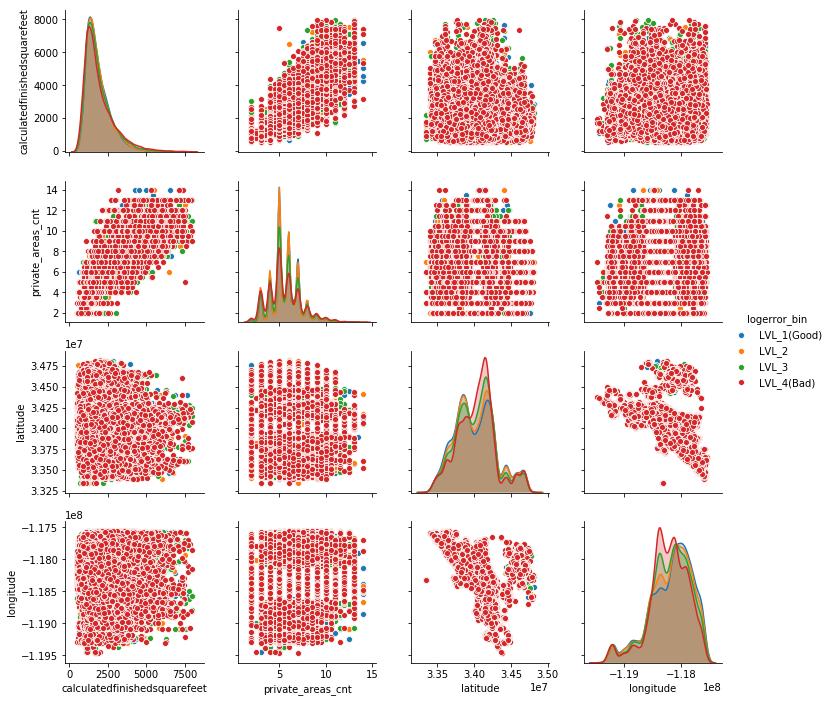

In [144]:
sns.pairplot(df, vars=['calculatedfinishedsquarefeet', 'private_areas_cnt',
                       'latitude', 'longitude'], hue='logerror_bin')

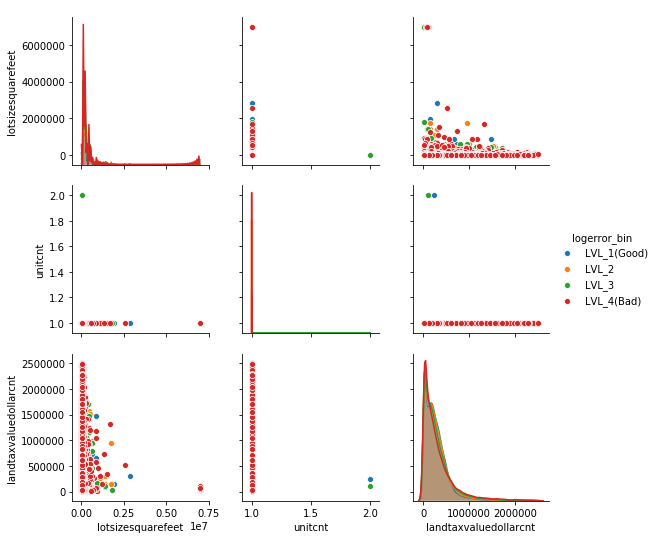

In [145]:
sns.pairplot(df, vars=['lotsizesquarefeet', 'unitcnt', 'landtaxvaluedollarcnt'], hue='logerror_bin')

Write a function that will use seaborn's relplot to plot 2 numeric (ordered) variables and 1 categorical variable. It will take, as input, a dataframe, column name indicated for each of the following: x, y, & hue.

**Error with seaborn on output of graph**

Write a function that will take, as input, a dataframe, a categorical column name, and a list of numeric column names. It will return a series of subplots: a swarmplot for each numeric column. X will be the categorical variable.

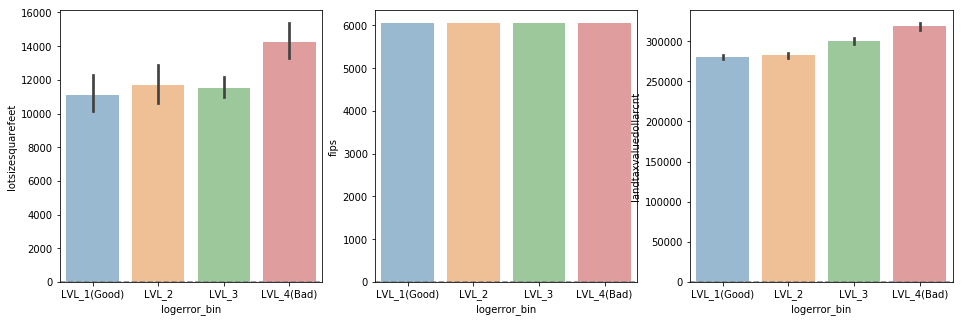

In [146]:
logerror_rate = df.logerror.mean()

features = ['lotsizesquarefeet', 'fips', 'landtaxvaluedollarcnt']

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

for i, feature in enumerate(features):
    sns.barplot('logerror_bin', feature, data=df, ax=ax[i], alpha=.5)
    ax[i].axhline(logerror_rate, ls='--', color='grey')

**Hypothosis:**

As we move up the size of each lot the logerror gets worse; the larger lot sizes have the most amount of bad log errors

Write a function that will take a dataframe and a list of categorical columns to plot each combination of variables in the chart type of your choice.

In [147]:
'''
print('Distributions of 24 columns')
plt.figure(figsize=(26, 24))
for i, col in enumerate(list(df.columns)[2:24]):
    plt.subplot(6, 4, i + 1)
    plt.hist(df[col])
    plt.title(col)
'''

"\nprint('Distributions of 24 columns')\nplt.figure(figsize=(26, 24))\nfor i, col in enumerate(list(df.columns)[2:24]):\n    plt.subplot(6, 4, i + 1)\n    plt.hist(df[col])\n    plt.title(col)\n"

Explore, explore, explore! Use the functions you wrote above to create plots, and explore some more with other plots.

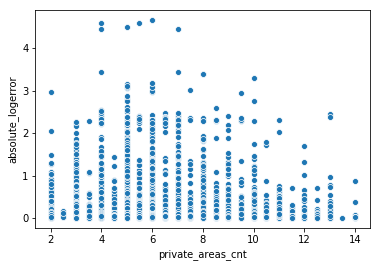

In [148]:
sns.scatterplot(df.private_areas_cnt, df.absolute_logerror)

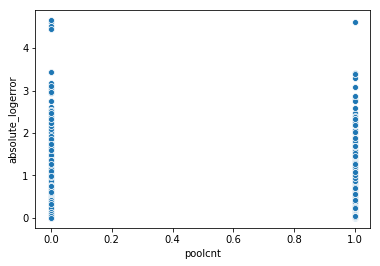

In [149]:
sns.scatterplot(df.poolcnt, df.absolute_logerror)

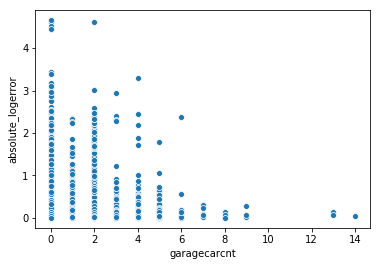

In [150]:
sns.scatterplot(df.garagecarcnt, df.absolute_logerror)

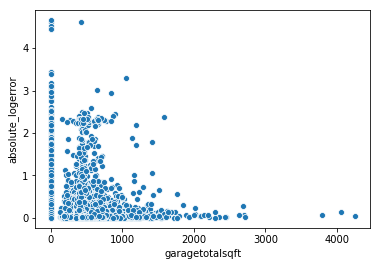

In [151]:
sns.scatterplot(df.garagetotalsqft, df.absolute_logerror)

**Hypothesis:**

Garage count < 5 has a large abount of bad logerrors... We are going to use clustering to cluster just the garage count and add the clusters to our model

Test, test, test!

**TTesting in progress***

In [152]:
stats.ttest_ind(df[df.fips > 6075].logerror.dropna(),
               df[df.fips < 6075].logerror.dropna())

Ttest_indResult(statistic=1.068451483736277, pvalue=0.28531919115137566)

In [153]:
stats.ttest_ind(df[df.regionidzip > 96995].logerror.dropna(),
               df[df.regionidzip < 96995].logerror.dropna())

Ttest_indResult(statistic=0.7823261786069449, pvalue=0.43402455947320606)

In [154]:
stats.ttest_ind(df[df.taxvaluedollarcnt > df.taxvaluedollarcnt.mean()].logerror.dropna(),
               df[df.taxvaluedollarcnt < df.taxvaluedollarcnt.mean()].logerror.dropna())

Ttest_indResult(statistic=0.20159343109452788, pvalue=0.8402349446243776)

**Winner, Winner, Chicken Dinner(s)!**

     - Found four different ttests that gave me a significant p-value

In [155]:
stats.ttest_ind(df[df.calculatedfinishedsquarefeet > 1660].logerror.dropna(),
               df[df.calculatedfinishedsquarefeet < 1660].logerror.dropna())

Ttest_indResult(statistic=9.489990389812524, pvalue=2.3534208169024236e-21)

In [156]:
stats.ttest_ind(df[df.yearbuilt > 1962].logerror.dropna(),
               df[df.yearbuilt < 1962].logerror.dropna())

Ttest_indResult(statistic=7.985776126310062, pvalue=1.4096918698559898e-15)

In [157]:
stats.ttest_ind(df[df.lotsizesquarefeet < 10000].logerror.dropna(),
               df[df.lotsizesquarefeet > 10000].logerror.dropna())

Ttest_indResult(statistic=-7.642731971210034, pvalue=2.143315880038566e-14)

In [158]:
stats.ttest_ind(df[df.landtaxvaluedollarcnt < 200000].logerror.dropna(),
               df[df.landtaxvaluedollarcnt > 200000].logerror.dropna())

Ttest_indResult(statistic=4.001810812619075, pvalue=6.289969037574019e-05)

**Chi^2'd testing in progress**

In [159]:
crosstab = pd.crosstab(df['assessmentyear'] > 2015, df['logerror_bin'])
stats.chi2_contingency(crosstab)

(16.671196153294254,
 0.0008257532893478351,
 3,
 array([[15299.51450663, 14852.48549337, 15100.0625665 , 15051.9374335 ],
        [13312.48549337, 12923.51450663, 13138.9374335 , 13097.0625665 ]]))

In [160]:
crosstab = pd.crosstab(df['bedroomcnt'], df['logerror_bin'])
stats.chi2_contingency(crosstab)

(945.0602033184741,
 3.802762631862998e-189,
 18,
 array([[  265.12325317,   257.37674683,   261.66697702,   260.83302298],
        [ 4363.49744627,  4236.00255373,  4306.61276335,  4292.88723665],
        [12983.17450521, 12603.82549479, 12813.91950415, 12773.08049585],
        [ 8550.16148826,  8300.33851174,  8438.69740902,  8411.80259098],
        [ 2116.16560261,  2054.33439739,  2088.57823473,  2081.92176527],
        [  292.77725757,   284.22274243,   288.96047031,   288.03952969],
        [   41.1004469 ,    39.8995531 ,    40.56464141,    40.43535859]]))

**Winner, Winner, Chicken Dinner!**

In [161]:
crosstab = pd.crosstab(df['fips'], df['logerror'])
chi2_value, p_value, dof, expected = stats.chi2_contingency(crosstab)

print("The p-value: {}".format(p_value))

The p-value: 0.0031145827589725583


Binning the landtaxvaluedollarcnt to then run a Chi2 test

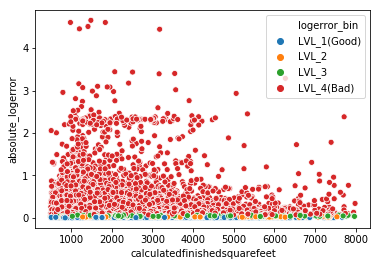

In [162]:
sns.scatterplot(df.calculatedfinishedsquarefeet, df.absolute_logerror, hue=df.logerror_bin)

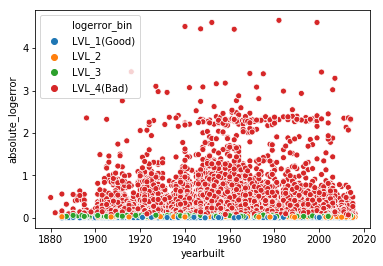

In [163]:
sns.scatterplot(df.yearbuilt, df.absolute_logerror, hue=df.logerror_bin)

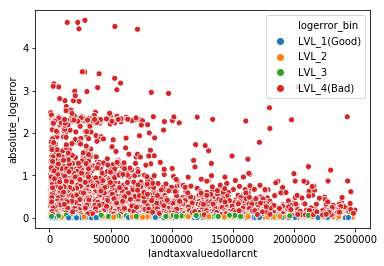

In [164]:
sns.scatterplot(df.landtaxvaluedollarcnt, df.absolute_logerror, hue=df.logerror_bin)

In [165]:
df['landtaxvaluedollarcnt_bin'] = pd.qcut(df.landtaxvaluedollarcnt, 4)

In [166]:
crosstab = pd.crosstab(df['landtaxvaluedollarcnt_bin'], df['logerror'])
chi2_value, p_value, dof, expected = stats.chi2_contingency(crosstab)

print("The p-value: {}".format(p_value))

The p-value: 0.1137479210441069


In [167]:
df.columns

Index(['id', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'fips', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolcnt', 'regionidzip', 'unitcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'parcelid.1', 'logerror', 'absolute_logerror', 'private_areas_cnt', 'logerror_bin', 'landtaxvaluedollarcnt_bin'], dtype='object')

In [168]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(df[['logerror', 'fips', 'yearbuilt', 'calculatedfinishedsquarefeet', 'private_areas_cnt', 'garagecarcnt', 'garagetotalsqft', 'poolcnt', 'absolute_logerror']])
df[['logerror', 'fips', 'yearbuilt', 'calculatedfinishedsquarefeet', 'private_areas_cnt', 'garagecarcnt', 'garagetotalsqft', 'poolcnt', 'absolute_logerror']]\
    = scaler.transform(df[['logerror', 'fips', 'yearbuilt', 'calculatedfinishedsquarefeet', 'private_areas_cnt', 'garagecarcnt', 'garagetotalsqft', 'poolcnt', 'absolute_logerror']])

# Exploration with Clustering

**Standardize Data**

In [169]:
from sklearn import preprocessing

df[['logerror']] = preprocessing.scale(df.logerror)

Perform clustering with logerror as the only feature used in the clustering algorithm. Decide on a number of clusters to use, and store the cluster predictions back onto your data frame as cluster_target. Look at the centroids that were produced in this process. What do they tell you?

### Cluster the Target Variable

In [170]:
from sklearn.cluster import KMeans

In [171]:
X1 = df[['logerror']]

In [172]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X1)

kmeans.predict(X1)

array([2, 1, 2, ..., 2, 2, 2], dtype=int32)

In [173]:
kmeans.cluster_centers_

array([[  1.98338373],
       [ -1.42694896],
       [ -0.02739089],
       [ 11.3740738 ],
       [-12.86939585]])

Perform clustering with logerror as the only feature used in the clustering algorithm. Decide on a number of clusters to use, and store the cluster predictions back onto your data frame as cluster_target. Look at the centroids that were produced in this process. What do they tell you?

In [174]:
cluster_target = pd.DataFrame(kmeans.cluster_centers_, columns=X1.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

In [175]:
df['cluster1'] = kmeans.predict(X1)
df.cluster1.value_counts()

2    100354
1      6776
0      5280
3       273
4        93
Name: cluster1, dtype: int64

Use the produced clusters to help you explore through visualization how logerror relates to other variables. (A common way to do this is to use color to indicate the cluster id, and the other variables can be your x and y axis. (hint: look at your swarmplot function))

In [176]:
X2 = df[['garagecarcnt']]

In [177]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X2)

kmeans.predict(X2)

array([1, 0, 1, ..., 0, 1, 1], dtype=int32)

In [178]:
cluster_target = pd.DataFrame(kmeans.cluster_centers_, columns=X1.columns)\
    .reset_index()\
    .rename({'index': 'cluster__'}, axis=1)\
    .set_index('cluster__')

In [179]:
df['cluster1'] = kmeans.predict(X2)
df.cluster1.value_counts()

1    73942
0    32273
2     4778
3     1783
Name: cluster1, dtype: int64

In [180]:
kmeans.cluster_centers_

array([[ 1.42857143e-01],
       [-4.53387328e-14],
       [ 7.14285714e-02],
       [ 2.46775098e-01]])

In [181]:
pd.DataFrame(kmeans.cluster_centers_, columns=X2.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,garagecarcnt
cluster,
0,1.428571e-01
1,-4.533873e-14
2,7.142857e-02
3,2.467751e-01


### Cluster Combination of Independent Variables

In [182]:
from sklearn.cluster import KMeans

In [183]:
X = df[['yearbuilt', 'fips', 'landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 'private_areas_cnt']]

In [184]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

array([2, 2, 0, ..., 0, 0, 2], dtype=int32)

In [185]:
kmeans.cluster_centers_

array([[6.17436134e-01, 1.45970352e-01, 8.01396406e+04, 1.57564435e-01,
        2.77954507e-01],
       [6.35746705e-01, 1.34809963e-01, 9.64879264e+05, 3.19675213e-01,
        4.06444348e-01],
       [6.21281322e-01, 1.87394783e-01, 2.79525113e+05, 1.73304501e-01,
        2.90353336e-01],
       [6.48169151e-01, 1.93102707e-01, 5.28547062e+05, 2.35272023e-01,
        3.45262694e-01],
       [6.55652305e-01, 1.17023371e-01, 1.73866739e+06, 3.96438456e-01,
        4.74440687e-01]])

In [186]:
pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)\
    .reset_index()\
    .rename({'index': 'cluster'}, axis=1)\
    .set_index('cluster')

,yearbuilt,fips,landtaxvaluedollarcnt,calculatedfinishedsquarefeet,private_areas_cnt
cluster,,,,,
0,0.617436,0.145970,8.013964e+04,0.157564,0.277955
1,0.635747,0.134810,9.648793e+05,0.319675,0.406444
2,0.621281,0.187395,2.795251e+05,0.173305,0.290353
3,0.648169,0.193103,5.285471e+05,0.235272,0.345263
4,0.655652,0.117023,1.738667e+06,0.396438,0.474441


In [187]:
df['cluster'] = kmeans.predict(X)
df.cluster.value_counts()

0    48738
2    37303
3    19085
1     5730
4     1920
Name: cluster, dtype: int64

0    48738
2    37303
3    19085
1     5730
4     1920
Name: cluster, dtype: int64

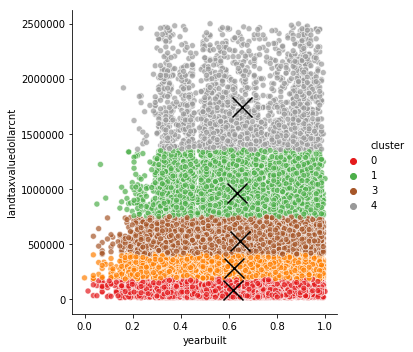

In [188]:
centers = df.groupby('cluster').mean()

sns.relplot(data=df, x='yearbuilt', y='landtaxvaluedollarcnt', hue='cluster', palette='Set1', alpha=.7)
plt.scatter(centers.yearbuilt, centers.landtaxvaluedollarcnt, s=400, c='black', marker='x', label='center')

df.cluster.value_counts()

<Figure size 2160x1440 with 0 Axes>

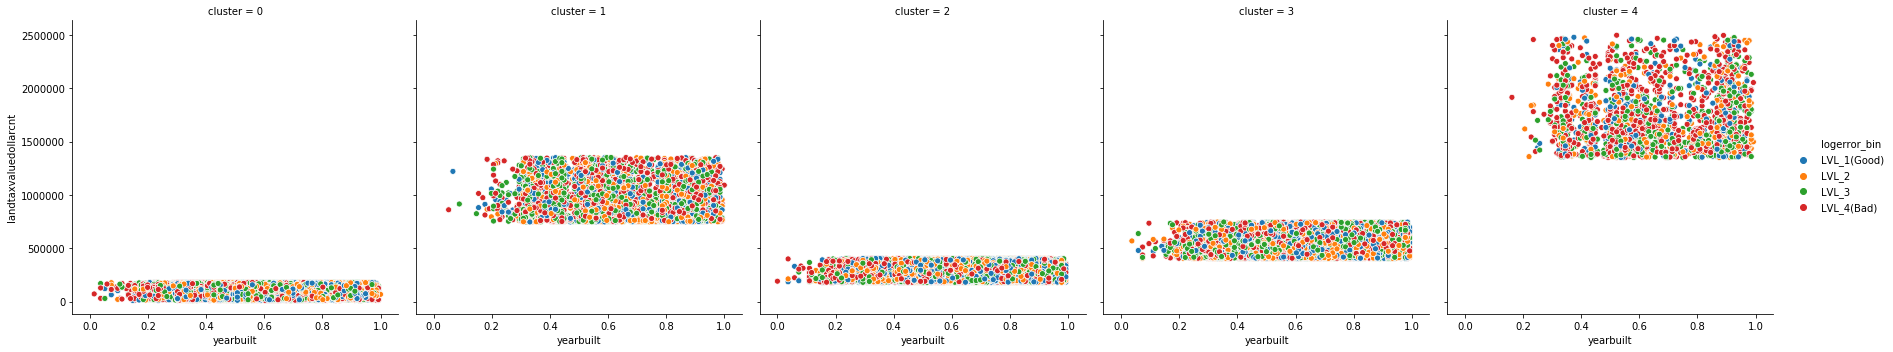

In [189]:
df['cluster'] = kmeans.predict(X)

plt.figure(figsize=(30,20))
sns.relplot(data=df, x='yearbuilt', y='landtaxvaluedollarcnt', hue='logerror_bin', col="cluster")

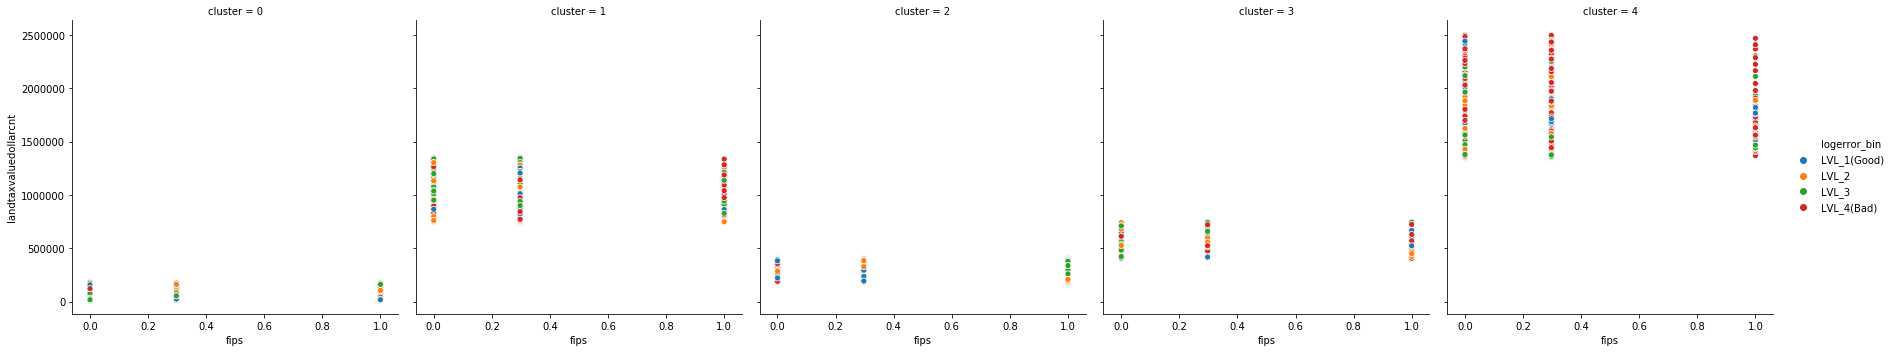

In [190]:
sns.relplot(data=df, x='fips', y='landtaxvaluedollarcnt', hue='logerror_bin', col="cluster")

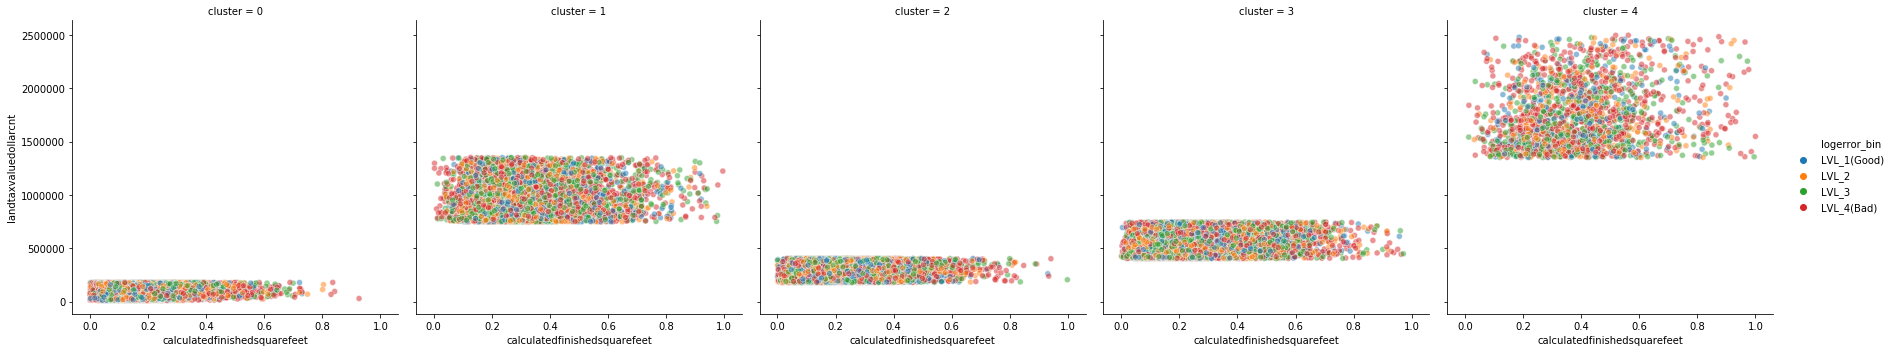

In [191]:
sns.relplot(data=df, x='calculatedfinishedsquarefeet',
            y='landtaxvaluedollarcnt', hue='logerror_bin', col="cluster", alpha=0.5)

   k           sse
0  1  1.065039e+16
1  2  4.335284e+15
2  3  2.035301e+15
3  4  1.194367e+15
4  5  7.701181e+14
5  6  5.395141e+14
6  7  3.914388e+14
7  8  2.980186e+14
8  9  2.358929e+14


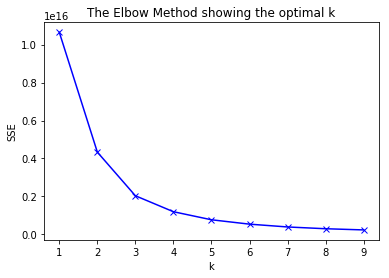

In [192]:
ks = range(1,10)
sse = []
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)

    # inertia: Sum of squared distances of samples to their closest cluster center.
    sse.append(kmeans.inertia_)

print(pd.DataFrame(dict(k=ks, sse=sse)))

plt.plot(ks, sse, 'bx-')
plt.xlabel('k')
plt.ylabel('SSE')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Test the Significance of Clusters

**Significance:** We need to see if our clusters mean anything compared to the logerror bins we've created. We will use the Chi2 tests to see

In [252]:
crosstab = pd.crosstab(df['cluster'] == 0, df['logerror_bin'])
stats.chi2_contingency(crosstab)

(126.768641181579,
 2.687642778709591e-27,
 3,
 array([[16246.85443711, 15772.14556289, 16035.05251117, 15983.94748883],
        [12365.14556289, 12003.85443711, 12203.94748883, 12165.05251117]]))

In [193]:
crosstab = pd.crosstab(df['cluster'] == 1, df['logerror_bin'])
stats.chi2_contingency(crosstab)

(390.8837713802878,
 2.088037137946209e-84,
 3,
 array([[27158.26197063, 26364.73802937, 26804.21360928, 26718.78639072],
        [ 1453.73802937,  1411.26197063,  1434.78639072,  1430.21360928]]))

In [194]:
crosstab = pd.crosstab(df['cluster'] == 2, df['logerror_bin'])
stats.chi2_contingency(crosstab)

(514.109678066925,
 4.176496407218839e-111,
 3,
 array([[19147.98783429, 18588.51216571, 18898.36531709, 18838.13468291],
        [ 9464.01216571,  9187.48783429,  9340.63468291,  9310.86531709]]))

In [195]:
crosstab = pd.crosstab(df['cluster'] == 3, df['logerror_bin'])
stats.chi2_contingency(crosstab)

(19.46108457006454,
 0.0002194868163686614,
 3,
 array([[23770.01216571, 23075.48783429, 23460.13468291, 23385.36531709],
        [ 4841.98783429,  4700.51216571,  4778.86531709,  4763.63468291]]))

In [196]:
crosstab = pd.crosstab(df['cluster'] == 4, df['logerror_bin'])
stats.chi2_contingency(crosstab)

(343.70265742738906,
 3.4451318351609787e-74,
 3,
 array([[28124.88359225, 27303.11640775, 27758.23387955, 27669.76612045],
        [  487.11640775,   472.88359225,   480.76612045,   479.23387955]]))

In [197]:
stats.ttest_ind(df[df.cluster == 1].logerror.dropna(),
               df[df.cluster == 3].logerror.dropna())

Ttest_indResult(statistic=2.3770918936865657, pvalue=0.017457276184553436)

In [198]:
dummies = pd.get_dummies(df['cluster']).rename(columns=lambda x: 'cluster_' + str(x))
df = pd.concat([df, dummies], axis=1)
### df = df.drop(['cluster'], inplace=True, axis=1)

Why? By reducing the noise of the continuous variable, we can possibly see trends easier by turning this continuous variable into clusters and then comparing those clusters with respect to other variables through visualizations or tests.

**ANSWER**

The trends were easily spotted as soon as we started to cluster different variables; as seen with the graphs above. I used landtaxvalue as my y-intercept for my clustering visualizations because it shows that the logerror worsens are you move to higher and higher values.

## Model Selection

### KNN Model

This model produced the highest train accuracy and the lowest test accuracy

In [244]:
X = df[['cluster', 'fips','yearbuilt', 
        'landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 
        'taxvaluedollarcnt', 'private_areas_cnt', 'garagecarcnt']]
y = df[['logerror_bin']]

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.70, random_state=123)

In [246]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [247]:
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [248]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.50


In [249]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

 LVL_1(Good)       0.48      0.65      0.55     19984
       LVL_2       0.49      0.53      0.51     19485
       LVL_3       0.50      0.44      0.47     19729
  LVL_4(Bad)       0.56      0.38      0.45     19745

   micro avg       0.50      0.50      0.50     78943
   macro avg       0.51      0.50      0.49     78943
weighted avg       0.51      0.50      0.49     78943



([<matplotlib.axis.XTick at 0x1a39cbb2e8>,
 <a list of 7 Text xticklabel objects>)

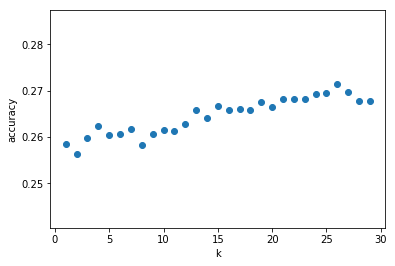

In [250]:
k_range = range(1, 30)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20, 25, 30])

In [251]:
print('Accuracy of KNN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of KNN classifier on test set: 0.27


### Decision Tree Model

In [207]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=123, class_weight='balanced', max_features=4, min_samples_split=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=10, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [208]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

In [209]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.33


In [210]:
sorted(y_train.logerror_bin.unique())

['LVL_1(Good)', 'LVL_2', 'LVL_3', 'LVL_4(Bad)']

In [211]:
y_train.logerror_bin.value_counts()

LVL_1(Good)    19984
LVL_4(Bad)     19745
LVL_3          19729
LVL_2          19485
Name: logerror_bin, dtype: int64

In [212]:
labels = sorted(y_train.logerror_bin.unique())
pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)

,LVL_1(Good),LVL_2,LVL_3,LVL_4(Bad)
LVL_1(Good),8062,3962,3392,4568
LVL_2,6599,4522,3212,5152
LVL_3,5382,3872,4339,6136
LVL_4(Bad),3833,3321,3246,9345


In [213]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

 LVL_1(Good)       0.34      0.40      0.37     19984
       LVL_2       0.29      0.23      0.26     19485
       LVL_3       0.31      0.22      0.26     19729
  LVL_4(Bad)       0.37      0.47      0.42     19745

   micro avg       0.33      0.33      0.33     78943
   macro avg       0.33      0.33      0.32     78943
weighted avg       0.33      0.33      0.32     78943



In [214]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.30


### Random Forest Model

In [215]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=5,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

In [216]:
rf.fit(X_train, y_train)
print(rf.feature_importances_)

[0.00327984 0.00447415 0.02609793 0.00110305 0.00951834 0.0051924
 0.00458757 0.03019118 0.00134222 0.00615881 0.08923649 0.38584484
 0.08326379 0.04958726 0.11681817 0.0553307  0.12797326]


In [217]:
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)

In [218]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.31


In [219]:
print(confusion_matrix(y_train, y_pred))

[[13945     0   393  5646]
 [12723     0   405  6357]
 [11669     0   465  7595]
 [ 9237     0   417 10091]]


In [220]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

 LVL_1(Good)       0.29      0.70      0.41     19984
       LVL_2       0.00      0.00      0.00     19485
       LVL_3       0.28      0.02      0.04     19729
  LVL_4(Bad)       0.34      0.51      0.41     19745

   micro avg       0.31      0.31      0.31     78943
   macro avg       0.23      0.31      0.22     78943
weighted avg       0.23      0.31      0.22     78943



In [221]:
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.31


### Logistic Regression

In [222]:
logit = LogisticRegression(C=1, random_state=0, solver='saga', class_weight='balanced', verbose=True)

In [223]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 5 seconds
max_iter reached after 5 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   18.9s finished


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='saga', tol=0.0001, verbose=True, warm_start=False)

In [224]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[-4.86344083e-09 -2.15964866e-09  8.39645001e-09  2.96136157e-09
  -7.67446813e-10 -4.86344083e-09 -2.15964866e-09  8.39645001e-09
   2.96136157e-09 -7.67446813e-10  5.95289106e-09  7.63196197e-09
  -4.81556803e-07  2.45135524e-12  2.46134677e-07  1.89606440e-09
   1.87370344e-09]
 [-2.03763033e-09 -1.20418549e-09  6.17301940e-09  1.46595269e-09
  -7.52009167e-10 -2.03763033e-09 -1.20418549e-09  6.17301940e-09
   1.46595269e-09 -7.52009167e-10  2.80670314e-09  5.40369998e-09
  -2.05592377e-07 -9.79107144e-11  7.73718040e-08  1.21007078e-09
   8.31581664e-10]
 [ 4.88723752e-10  9.02127477e-10 -1.79523237e-09 -3.03975796e-10
  -6.85065584e-11  4.88723752e-10  9.02127477e-10 -1.79523237e-09
  -3.03975796e-10 -6.85065584e-11 -1.18511813e-09 -1.39890694e-09
   7.15868861e-08  9.42220110e-11 -3.39161330e-08  7.85683815e-14
  -3.55783668e-10]
 [ 6.26584120e-09  2.41239226e-09 -1.23205211e-08 -3.65360700e-09
   1.41578901e-09  6.26584120e-09  2.41239226e-09 -1.23205211e-08
  -3

In [225]:
y_pred = logit.predict(X_train)
y_pred_proba = logit.predict_proba(X_train)

In [226]:
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.25


In [227]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

 LVL_1(Good)       0.25      0.38      0.30     19984
       LVL_2       0.00      0.00      0.00     19485
       LVL_3       0.00      0.00      0.00     19729
  LVL_4(Bad)       0.25      0.63      0.36     19745

   micro avg       0.25      0.25      0.25     78943
   macro avg       0.13      0.25      0.17     78943
weighted avg       0.13      0.25      0.17     78943



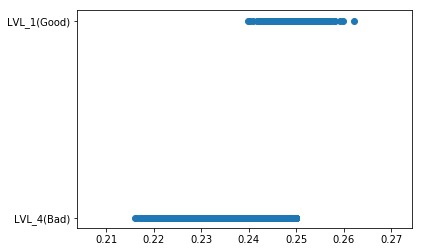

In [228]:
y_pred_proba = [i[1] for i in y_pred_proba]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(y_pred_proba, y_pred)

In [229]:
print('Accuracy of Logistic Regression classifier on test set: {:.2f}'
     .format(logit.score(X_test, y_test)))

Accuracy of Logistic Regression classifier on test set: 0.25


### Ridge Regression Model

In [258]:
X = df[['cluster', 'fips','yearbuilt', 
        'landtaxvaluedollarcnt', 'calculatedfinishedsquarefeet', 
        'taxvaluedollarcnt', 'private_areas_cnt', 'garagecarcnt']]
y = df[['logerror']]

In [259]:
X_traino, X_test0, y_train0, y_testo = train_test_split(X, y, train_size=.70, random_state=123)

In [260]:
from sklearn.linear_model import Ridge
ridgereg = Ridge(alpha=.05,normalize=True)
ridgereg.fit(X_traino, y_train0)

Ridge(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [261]:
y_pred = ridgereg.predict(X_traino)

In [262]:
print('Accuracy of Logistic Regression classifier on training set: {:.10f}'
     .format(ridgereg.score(X_traino, y_train0)))

Accuracy of Logistic Regression classifier on training set: 0.0035857300


- Not looking for a model that predicts the exact logerror; more so in the general range of the logerror

# Summary

Goal has been accomplished! We have improved the model from .004 to .31 on the test set :)